In [2]:
import os
import tensorflow as tf

# Evita la asignación completa de memoria GPU al inicio
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# Listar dispositivos GPU disponibles
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Establecer crecimiento dinámico de la memoria GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) configurada(s) correctamente con crecimiento dinámico.")
    except RuntimeError as e:
        print(f"Error al configurar la GPU: {e}")
else:
    print("No se detectó ninguna GPU disponible.")

# Activar compilación JIT (XLA) para optimización adicional
tf.config.optimizer.set_jit(True)


1 GPU(s) configurada(s) correctamente con crecimiento dinámico.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

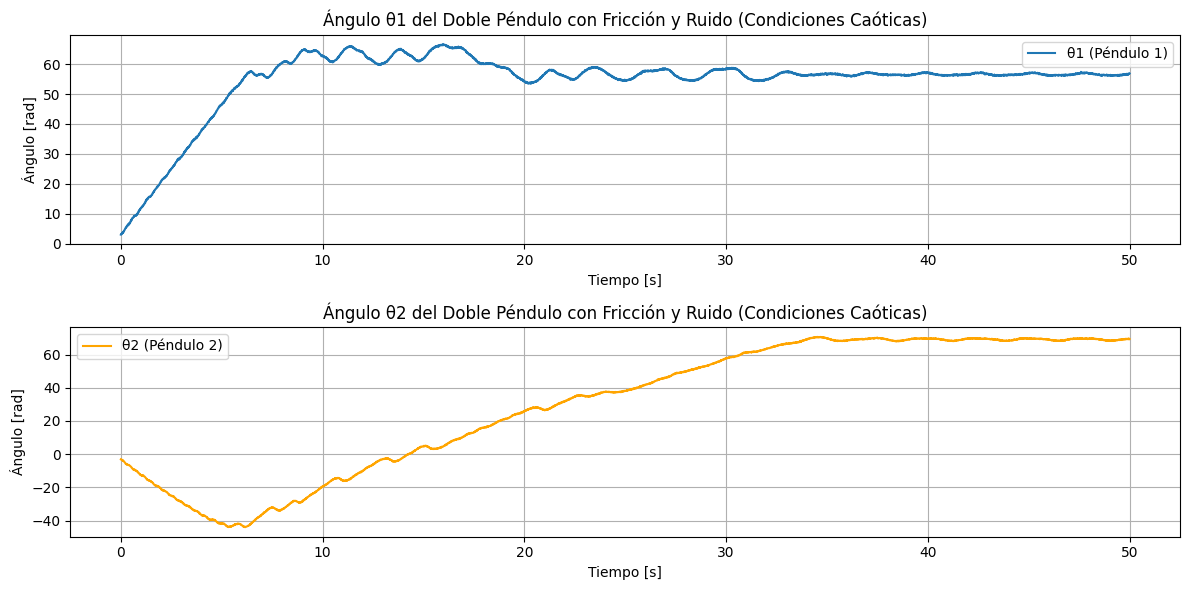

In [4]:
# Parámetros del doble péndulo
g = 9.81  
L1, L2 = 1.0, 1.0  # Longitudes de los péndulos
m1, m2 = 1.0, 1.0  # Masas
b1, b2 = 0.05, 0.05  # Fricción en las juntas
sigma = 0.1  # Ruido blanco gaussiano

# Condiciones iniciales caóticas
theta1_0, theta2_0 = np.radians(179), np.radians(-179)
omega1_0, omega2_0 = 5.0, -5.0
y0 = [theta1_0, omega1_0, theta2_0, omega2_0]

t_span = (0, 50)  
t_eval = np.linspace(t_span[0], t_span[1], 5000)  

# Ecuaciones del doble péndulo con fricción y ruido
def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y

    noise1 = np.random.normal(0, sigma)
    noise2 = np.random.normal(0, sigma)

    delta_theta = theta2 - theta1

    M11 = (m1 + m2) * L1
    M12 = m2 * L2 * np.cos(delta_theta)
    M21 = L1 * np.cos(delta_theta)
    M22 = L2

    det = M11 * M22 - M12 * M21  # Determinante

    f1 = -m2 * L2 * omega2**2 * np.sin(delta_theta) - (m1 + m2) * g * np.sin(theta1) - b1 * omega1 + noise1
    f2 = L1 * omega1**2 * np.sin(delta_theta) - g * np.sin(theta2) - b2 * omega2 + noise2

    domega1_dt = (M22 * f1 - M12 * f2) / det
    domega2_dt = (-M21 * f1 + M11 * f2) / det

    return [omega1, domega1_dt, omega2, domega2_dt]

# Resolver ecuación diferencial
solution = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval)

# Extraer datos con ruido adicional
theta1_data = solution.y[0] + np.random.normal(0, sigma, size=len(t_eval))
theta2_data = solution.y[2] + np.random.normal(0, sigma, size=len(t_eval))

# Graficar theta1_data y theta2_data
plt.figure(figsize=(12, 6))

# Graficar theta1
plt.subplot(2, 1, 1)
plt.plot(t_eval, theta1_data, label="θ1 (Péndulo 1)")
plt.title("Ángulo θ1 del Doble Péndulo con Fricción y Ruido (Condiciones Caóticas)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Ángulo [rad]")
plt.grid(True)
plt.legend()

# Graficar theta2
plt.subplot(2, 1, 2)
plt.plot(t_eval, theta2_data, label="θ2 (Péndulo 2)", color="orange")
plt.title("Ángulo θ2 del Doble Péndulo con Fricción y Ruido (Condiciones Caóticas)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Ángulo [rad]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# ============================================================
# 2) Construir dataset con ventanas deslizantes MULTIVARIABLE
# ============================================================
window_size = 100
X, Y = [], []  # Cada muestra: (window_size, 2); target: [θ1(t+1), θ2(t+1)]
for i in range(len(t_eval) - window_size):
    window_theta1 = theta1_data[i:i+window_size]
    window_theta2 = theta2_data[i:i+window_size]
    window_input = np.column_stack([window_theta1, window_theta2])
    target = [theta1_data[i+window_size], theta2_data[i+window_size]]
    X.append(window_input)
    Y.append(target)
X = np.array(X)  # Shape: (num_samples, window_size, 2)
Y = np.array(Y)  # Shape: (num_samples, 2)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (4900, 100, 2)
Y shape: (4900, 2)


In [16]:
# ============================================================
# 3) División time-based split: Train, Val, Test
# ============================================================
train_size = int(len(X) * 0.70)
val_size   = int(len(X) * 0.15)  # ~15% para validación
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size + val_size], Y[train_size:train_size + val_size]
X_test, Y_test = X[train_size + val_size:], Y[train_size + val_size:]
print("Shapes:")
print("  X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("  X_val:  ", X_val.shape,   "Y_val:  ", Y_val.shape)
print("  X_test: ", X_test.shape,  "Y_test: ", Y_test.shape)

Shapes:
  X_train: (3430, 100, 2) Y_train: (3430, 2)
  X_val:   (735, 100, 2) Y_val:   (735, 2)
  X_test:  (735, 100, 2) Y_test:  (735, 2)


In [17]:
# ============================================================
# 4) Escalado MinMax en 2 canales
# ============================================================
# Escalar X: aplanamos a 2D, ajustamos con el train y luego transformamos
scaler_x = MinMaxScaler(feature_range=(-1,1))
X_train_2d = X_train.reshape(-1, 2)
scaler_x.fit(X_train_2d)
X_train = scaler_x.transform(X_train_2d).reshape(X_train.shape)
X_val = scaler_x.transform(X_val.reshape(-1,2)).reshape(X_val.shape)
X_test = scaler_x.transform(X_test.reshape(-1,2)).reshape(X_test.shape)

# Escalar Y
scaler_y = MinMaxScaler(feature_range=(-1,1))
scaler_y.fit(Y_train)
Y_train = scaler_y.transform(Y_train)
Y_val = scaler_y.transform(Y_val)
Y_test = scaler_y.transform(Y_test)
print("X_train shape:", X_train.shape, "Y_train shape:", Y_train.shape)

X_train shape: (3430, 100, 2) Y_train shape: (3430, 2)


In [21]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(512, input_shape=(window_size, 2), return_sequences=True),
        Dropout(0.2),
        LSTM(256, return_sequences=True),
        Dropout(0.2),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.3352 - r2_score: -77.0703 - val_loss: 0.2377 - val_r2_score: -13.7085
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0955 - r2_score: -29.6215 - val_loss: 0.0050 - val_r2_score: 0.7402
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0295 - r2_score: -8.1678 - val_loss: 0.0281 - val_r2_score: -0.3941
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0624 - r2_score: -27.0341 - val_loss: 0.0068 - val_r2_score: 0.6268
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0451 - r2_score: -20.1205 - val_loss: 0.0356 - val_r2_score: -0.7202
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0429 - r2_score: -7.7520 - val_loss: 0.0097 - val_r2_score: 0.5639
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0393 - r2_score: -7.2341 - val_loss: 0.0346 - val_r2_score: -0.4606
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0193 

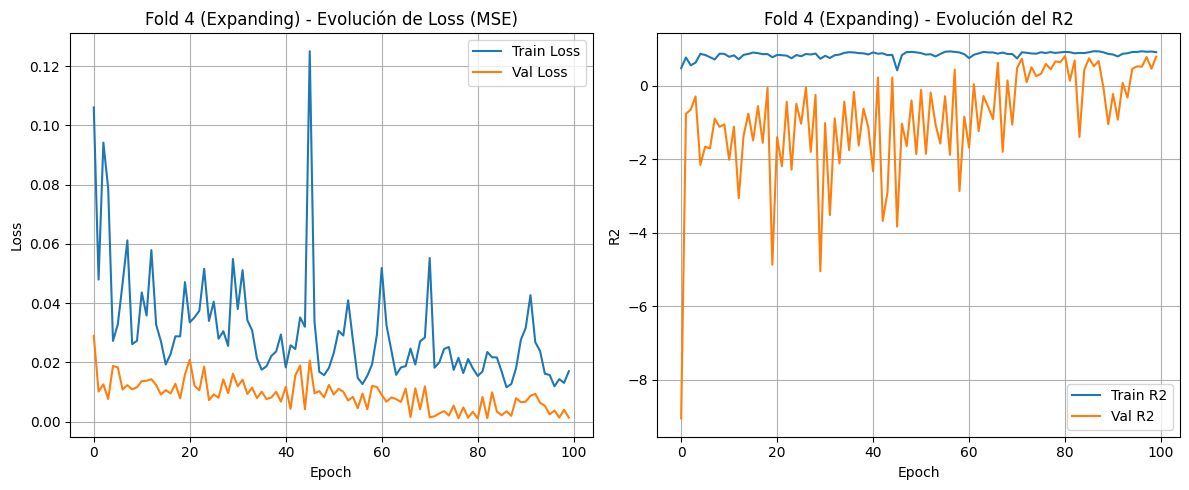

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


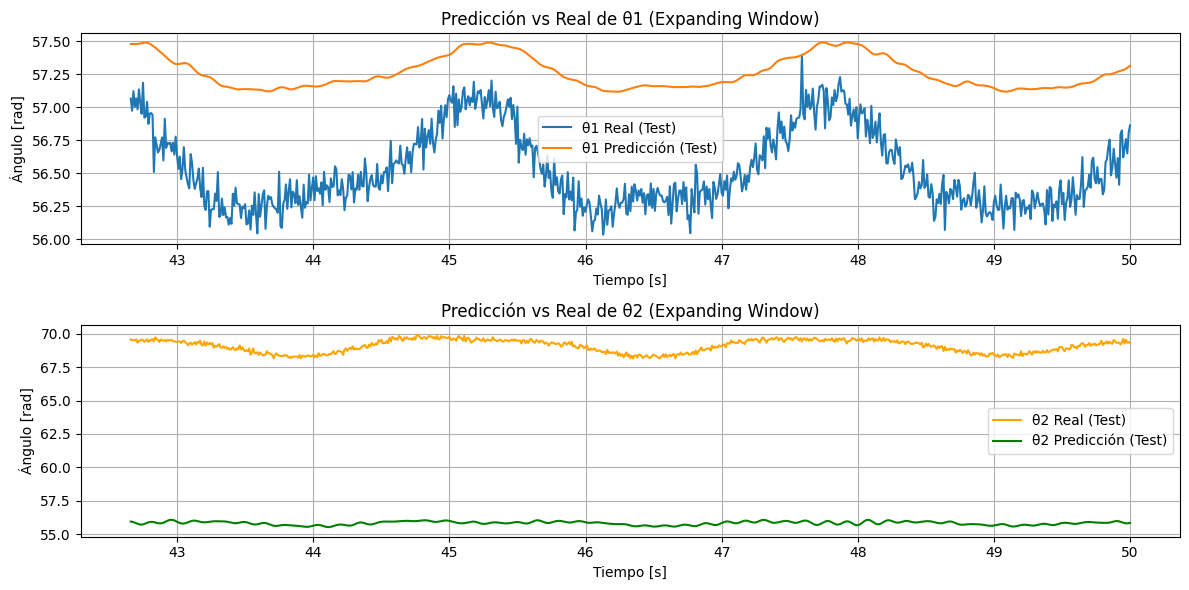

Métricas Globales en Test (Expanding Window):
MSE: 88.3009
MAE: 6.9985
R2: -395.4474


In [23]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

reduce_lr

In [24]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(512, input_shape=(window_size, 2), return_sequences=True),
        Dropout(0.2),
        LSTM(256, return_sequences=True),
        Dropout(0.2),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7, verbose=1)

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        callbacks=[reduce_lr],
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.3159 - r2_score: -72.4521 - val_loss: 0.2962 - val_r2_score: -19.9530 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.1594 - r2_score: -63.1726 - val_loss: 0.0624 - val_r2_score: -4.3307 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0437 - r2_score: -10.3113 - val_loss: 0.0248 - val_r2_score: -0.2909 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0598 - r2_score: -25.7186 - val_loss: 0.0455 - val_r2_score: -2.7257 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0565 - r2_score: -23.1406 - val_loss: 0.0340 - val_r2_score: -0.5540 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0620 - r2_score: -12.1451 - val_loss: 0.0417 - val_r2_score: -0.9035 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - l

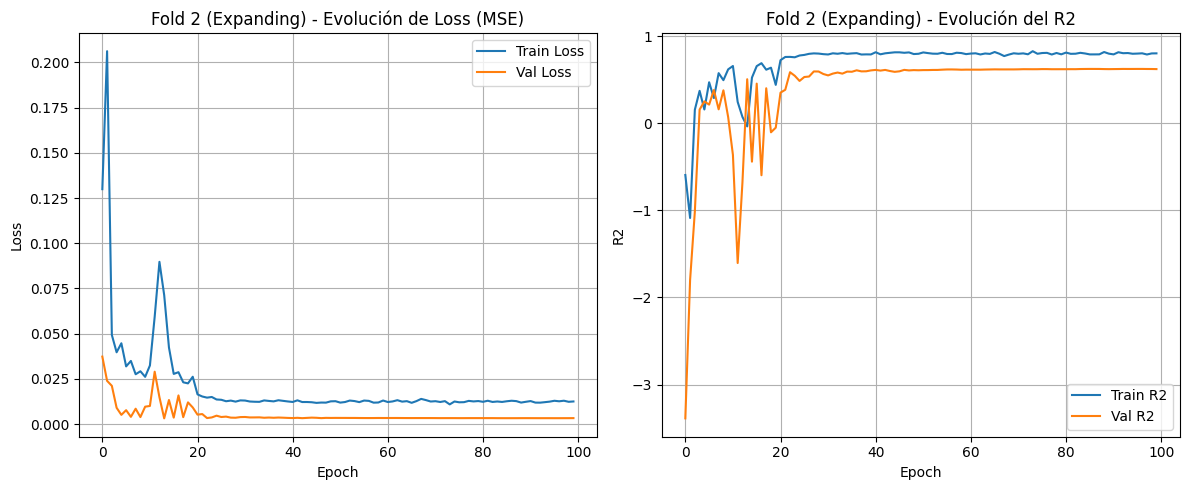

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


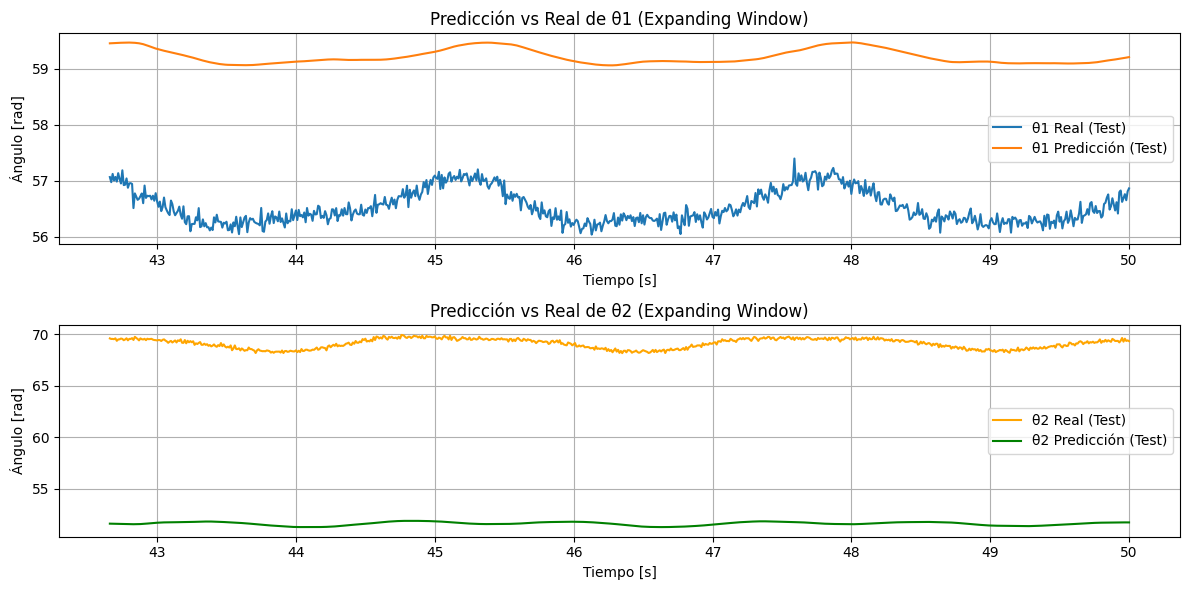

Métricas Globales en Test (Expanding Window):
MSE: 155.9012
MAE: 10.0701
R2: -722.2098


In [26]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

Dropout(0.3) - BEST

In [27]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(512, input_shape=(window_size, 2), return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7, verbose=1)

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        callbacks=[reduce_lr],
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.3560 - r2_score: -82.7459 - val_loss: 0.1472 - val_r2_score: -11.4971 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.3174 - r2_score: -61.0430 - val_loss: 0.0827 - val_r2_score: -6.0184 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0745 - r2_score: -13.0406 - val_loss: 0.0286 - val_r2_score: -0.4057 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0576 - r2_score: -8.3427 - val_loss: 0.0170 - val_r2_score: 0.0406 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1268 - r2_score: -38.8908 - val_loss: 0.0649 - val_r2_score: -2.3051 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0652 - r2_score: -20.1086 - val_loss: 0.0143 - val_r2_score: 0.3059 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss:

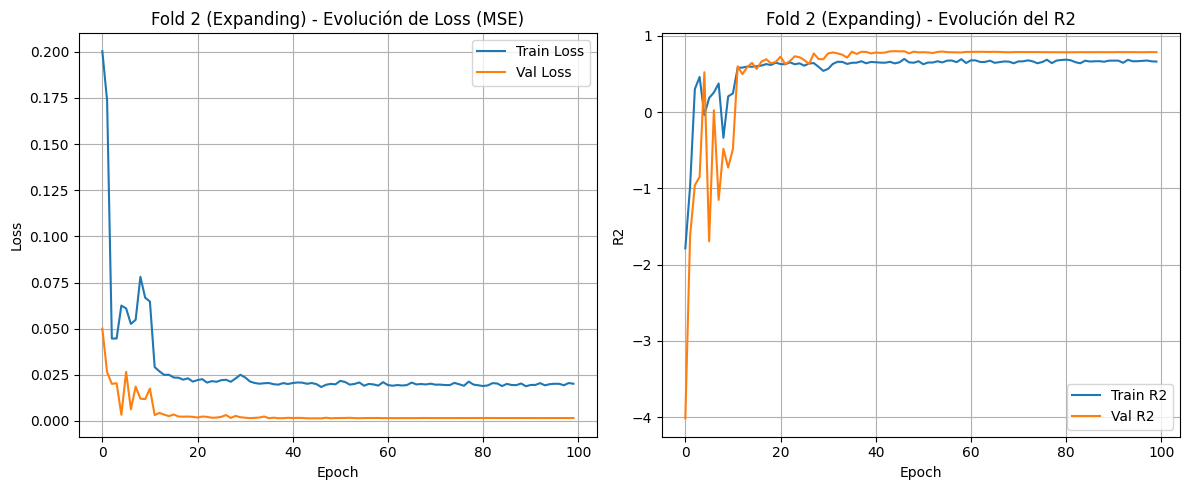

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


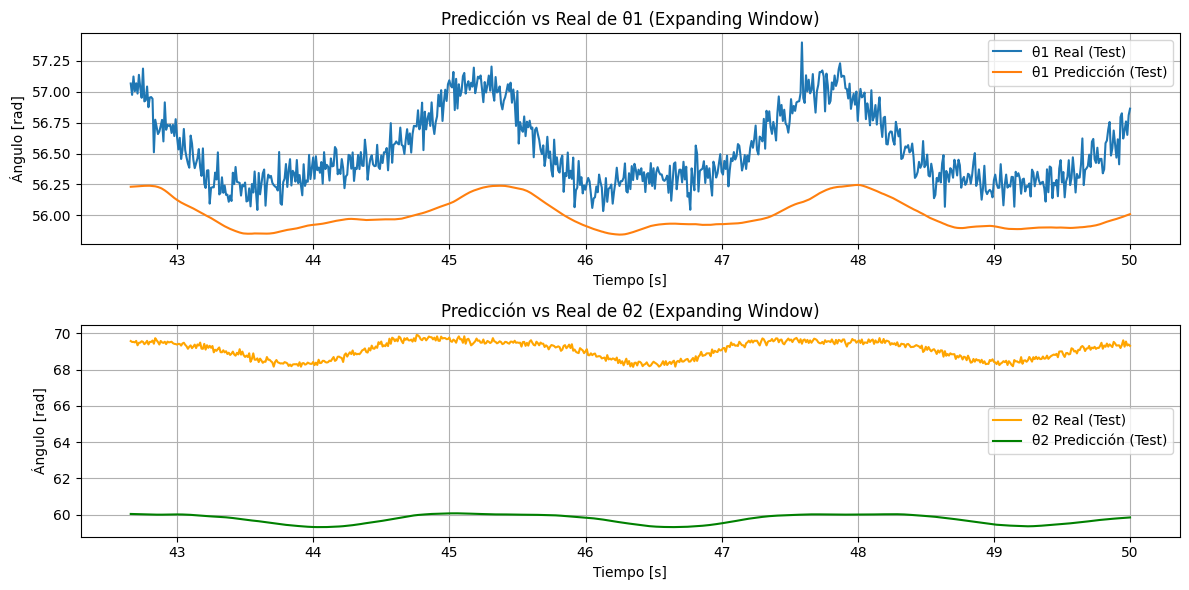

Métricas Globales en Test (Expanding Window):
MSE: 43.8218
MAE: 4.9307
R2: -195.8376


In [29]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

kernel_regularizer=l2(1e-4)

Dropout(0.2)

In [30]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(512, input_shape=(window_size, 2), return_sequences=True, kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7, verbose=1)

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        callbacks=[reduce_lr],
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.5193 - r2_score: -83.3046 - val_loss: 0.4109 - val_r2_score: -17.8540 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.2402 - r2_score: -17.0923 - val_loss: 0.1268 - val_r2_score: 0.6370 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1834 - r2_score: -31.1018 - val_loss: 0.1844 - val_r2_score: -1.7513 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2313 - r2_score: -38.1731 - val_loss: 0.1811 - val_r2_score: -3.2107 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1666 - r2_score: -10.2080 - val_loss: 0.1813 - val_r2_score: -2.2017 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1812 - r2_score: -9.6621 - val_loss: 0.1688 - val_r2_score: -2.0648 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - los

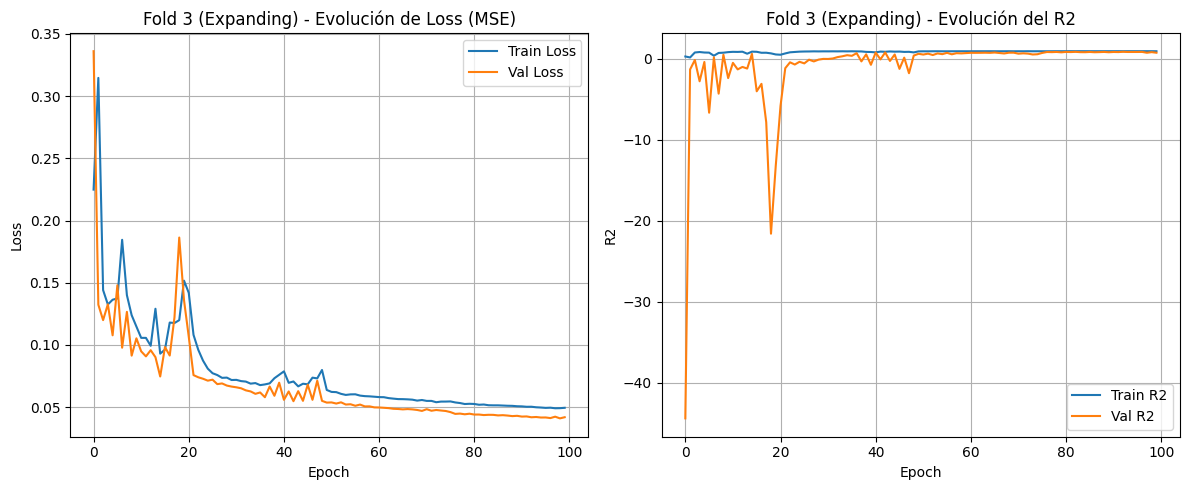

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


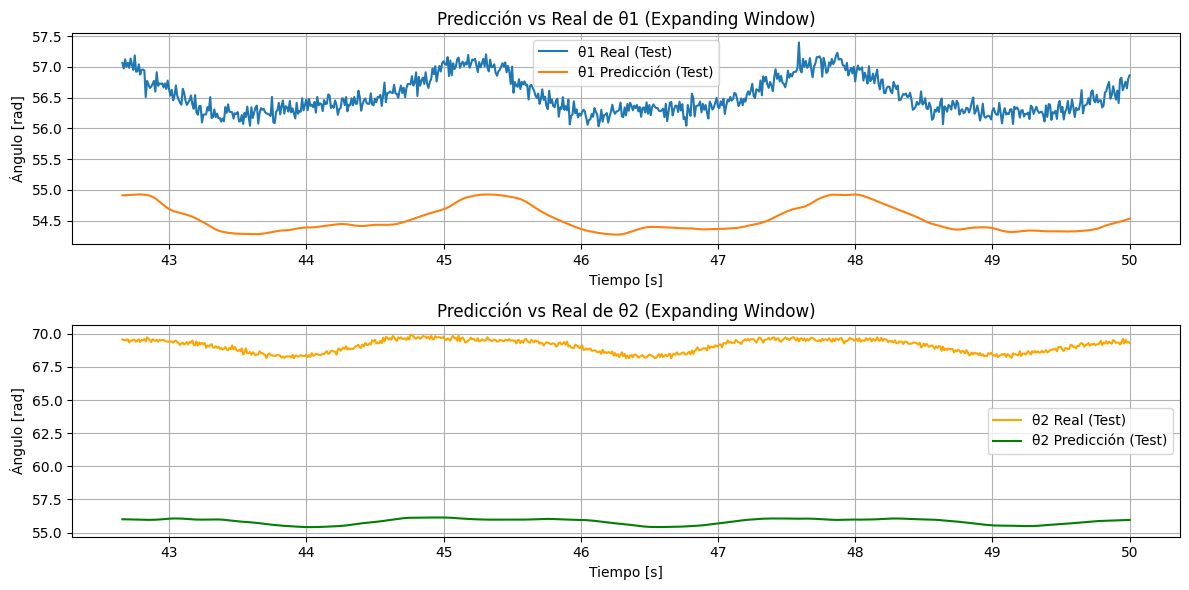

Métricas Globales en Test (Expanding Window):
MSE: 89.8295
MAE: 7.6262
R2: -415.0938


In [32]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

kernel_regularizer=l2(1e-5)

Dropout(0.3)

In [33]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(512, input_shape=(window_size, 2), return_sequences=True, kernel_regularizer=l2(1e-5)),
        Dropout(0.3),
        LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-5)),
        Dropout(0.3),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-5)),
        Dropout(0.3),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
        Dropout(0.3),
        LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
        Dropout(0.3),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7, verbose=1)

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        callbacks=[reduce_lr],
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.3521 - r2_score: -82.0778 - val_loss: 0.3475 - val_r2_score: -23.8934 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.1686 - r2_score: -57.3496 - val_loss: 0.1058 - val_r2_score: -6.9651 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0888 - r2_score: -25.1696 - val_loss: 0.0446 - val_r2_score: -0.8414 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0819 - r2_score: -22.7175 - val_loss: 0.0725 - val_r2_score: -3.3284 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0575 - r2_score: -15.8009 - val_loss: 0.0750 - val_r2_score: -1.8915 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0900 - r2_score: -16.1082 - val_loss: 0.0325 - val_r2_score: -0.0104 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - l

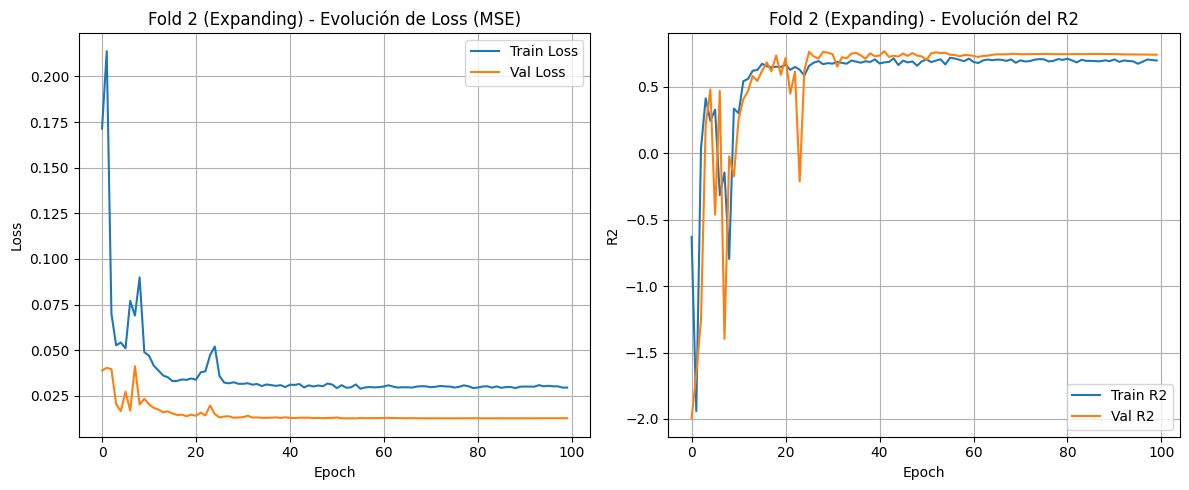

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


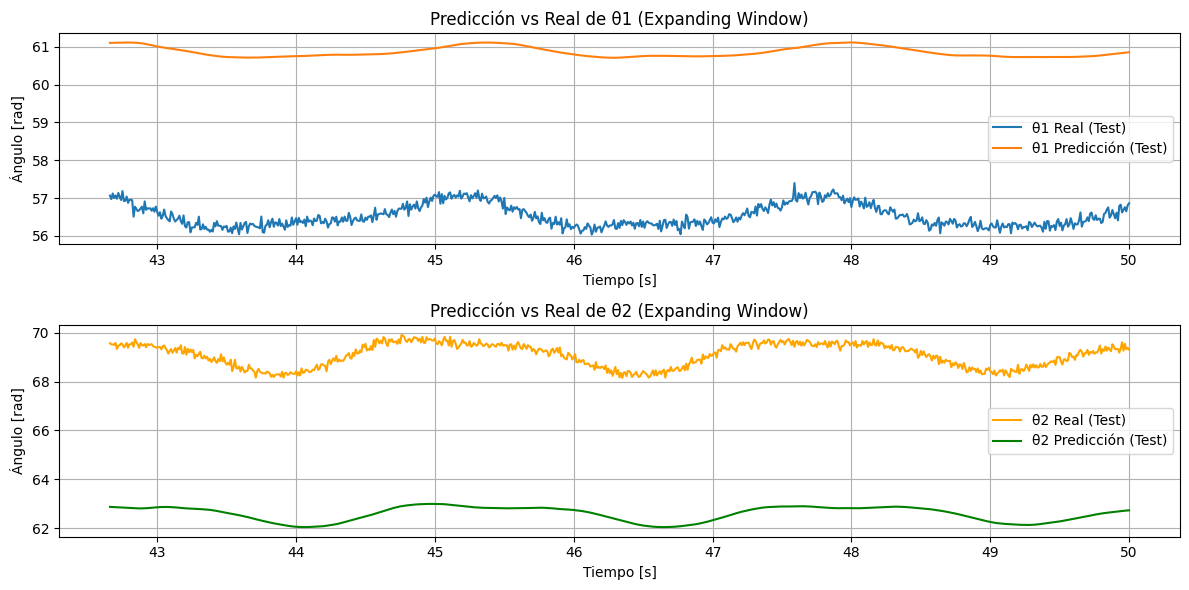

Métricas Globales en Test (Expanding Window):
MSE: 30.5667
MAE: 5.4162
R2: -205.1409


In [35]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

LayerNormalization

In [36]:
from tensorflow.keras.layers import LSTM, LayerNormalization

n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(512, input_shape=(window_size, 2), return_sequences=True, kernel_regularizer=l2(1e-5)),
        LayerNormalization(),
        Dropout(0.2),
        LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-5)),
        LayerNormalization(),
        Dropout(0.2),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-5)),
        LayerNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
        LayerNormalization(),
        Dropout(0.2),
        LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-5)),
        LayerNormalization(),
        Dropout(0.2),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7, verbose=1)

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        callbacks=[reduce_lr],
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-03-21 03:03:12.206632: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 76 bytes spill stores, 76 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 1.3787 - r2_score: -448.1974 - val_loss: 1.0019 - val_r2_score: -61.6757 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 0.4975 - r2_score: -141.4521 - val_loss: 0.2435 - val_r2_score: -16.7775 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5022 - r2_score: -140.2722 - val_loss: 0.1347 - val_r2_score: -6.7971 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5538 - r2_score: -104.4798 - val_loss: 0.0644 - val_r2_score: -2.8697 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6686 - r2_score: -126.1799 - val_loss: 0.2050 - val_r2_score: -9.0322 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.3890 - r2_score: -81.0603 - val_loss: 0.1661 - val_r2_score: -6.3003 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/st

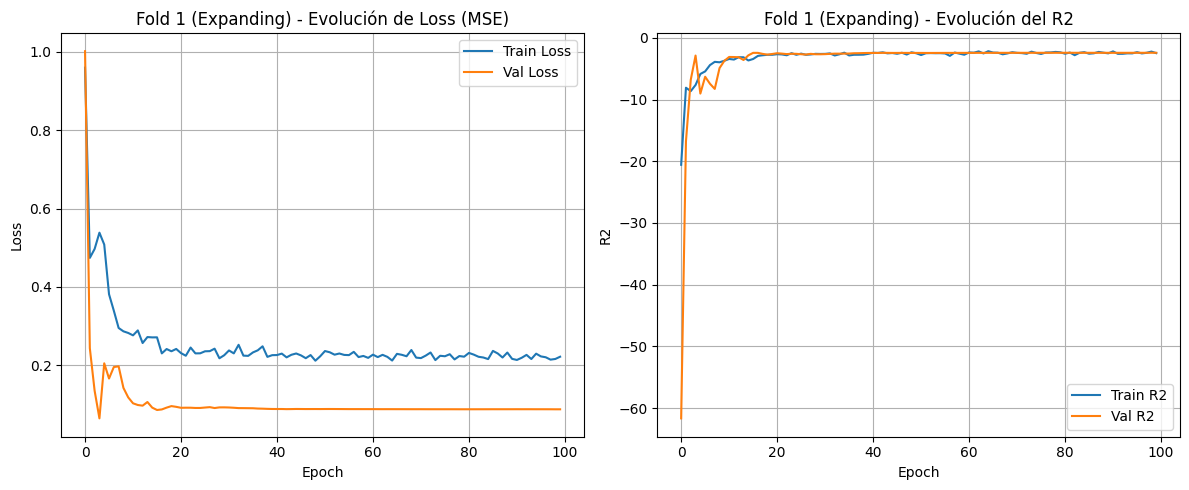

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


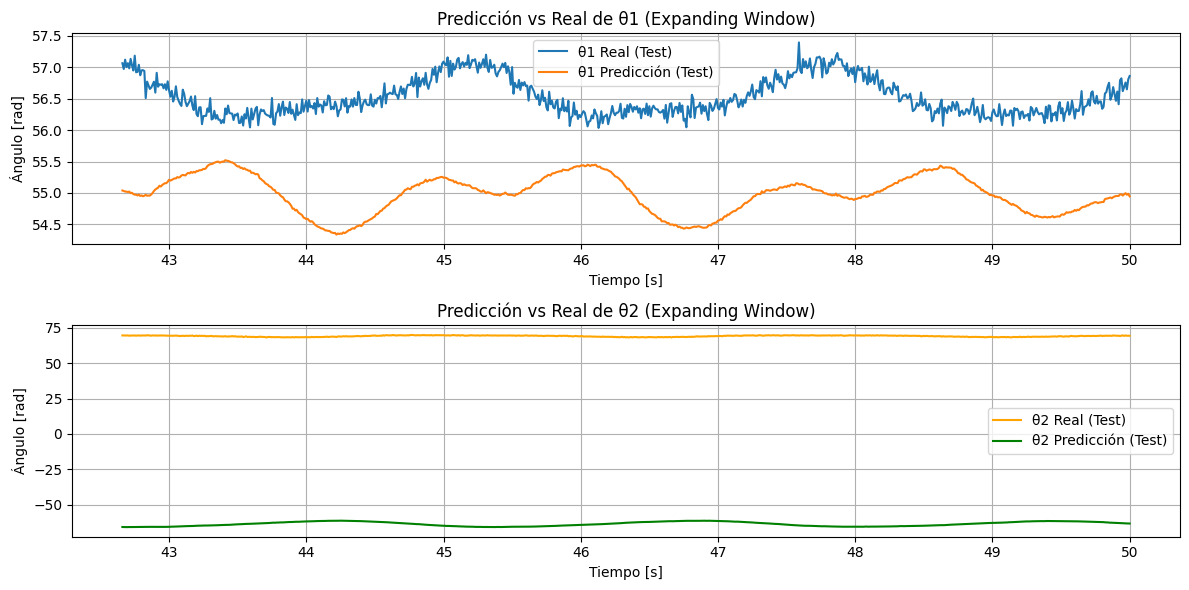

Métricas Globales en Test (Expanding Window):
MSE: 8812.6381
MAE: 67.1402
R2: -39362.2208


In [38]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

dropout = 0.4

In [39]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(512, input_shape=(window_size, 2), return_sequences=True),
        Dropout(0.4),
        LSTM(256, return_sequences=True),
        Dropout(0.4),
        LSTM(128, return_sequences=True),
        Dropout(0.4),
        LSTM(64, return_sequences=True),
        Dropout(0.4),
        LSTM(32, return_sequences=False),
        Dropout(0.4),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7, verbose=1)

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        callbacks=[reduce_lr],
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.3716 - r2_score: -79.4650 - val_loss: 0.2621 - val_r2_score: -17.4666 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.1469 - r2_score: -24.3151 - val_loss: 0.0164 - val_r2_score: 0.1472 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0736 - r2_score: -17.8741 - val_loss: 0.0639 - val_r2_score: -1.6536 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1193 - r2_score: -39.2972 - val_loss: 0.0547 - val_r2_score: -2.4619 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0697 - r2_score: -12.1246 - val_loss: 0.0239 - val_r2_score: -0.1052 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0579 - r2_score: -10.3630 - val_loss: 0.0432 - val_r2_score: -0.8559 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - los

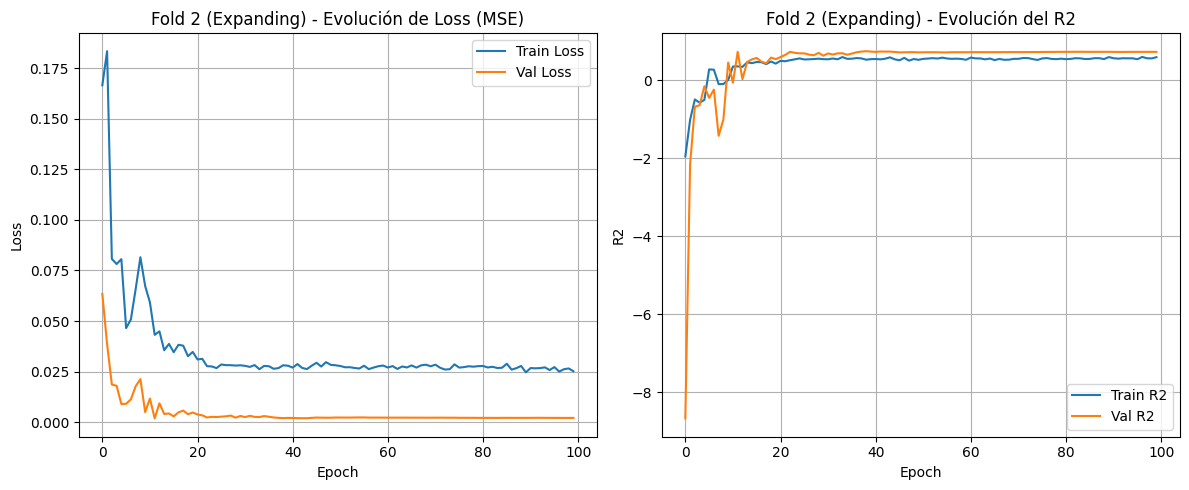

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


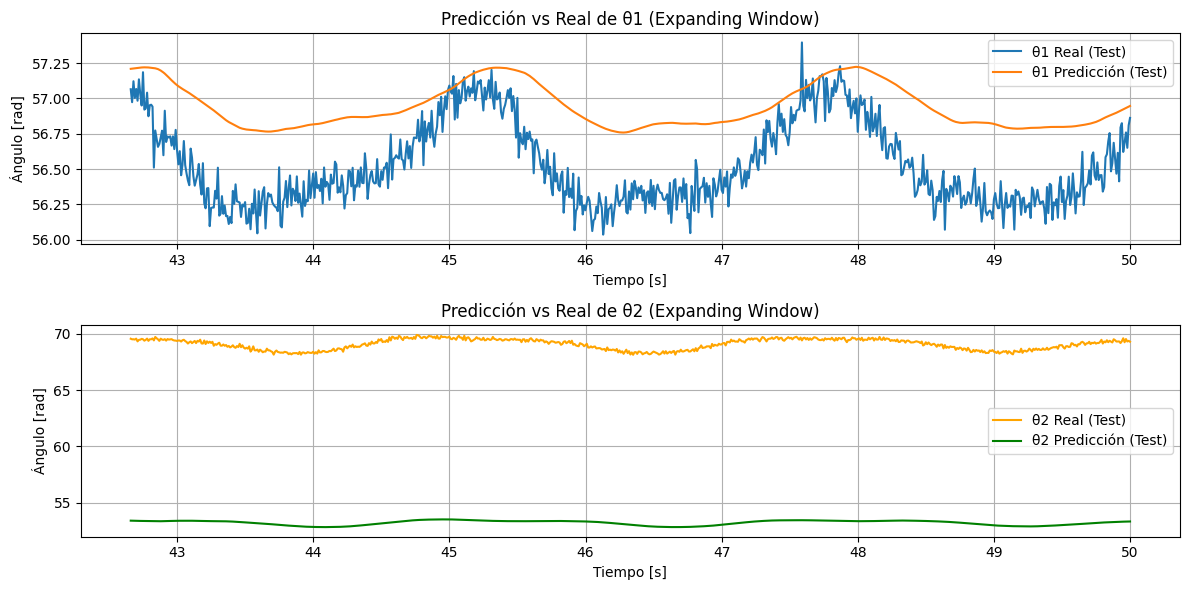

Métricas Globales en Test (Expanding Window):
MSE: 125.9520
MAE: 8.1387
R2: -562.2106


In [41]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

Sin dropout

In [42]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(512, input_shape=(window_size, 2), return_sequences=True),
        LSTM(256, return_sequences=True),
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=True),
        LSTM(32, return_sequences=False),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.3475 - r2_score: -86.1675 - val_loss: 0.2444 - val_r2_score: -16.3571
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1414 - r2_score: -58.0068 - val_loss: 0.0237 - val_r2_score: -0.7920
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0318 - r2_score: -11.6015 - val_loss: 0.0737 - val_r2_score: -2.3843
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0305 - r2_score: -13.9566 - val_loss: 0.0054 - val_r2_score: 0.7001
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0127 - r2_score: -4.8022 - val_loss: 0.0243 - val_r2_score: -0.6359
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0188 - r2_score: -1.8310 - val_loss: 0.0214 - val_r2_score: -0.0544
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0769 - r2_score: -11.1431 - val_loss: 0.0278 - val_r2_score: -0.2414
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0165 - r2_score: -0.01

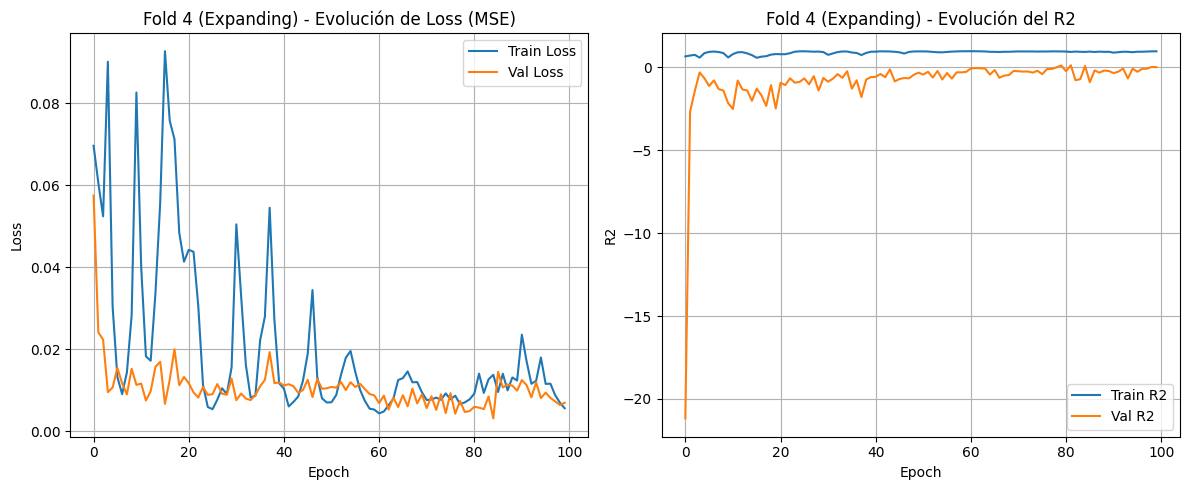

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


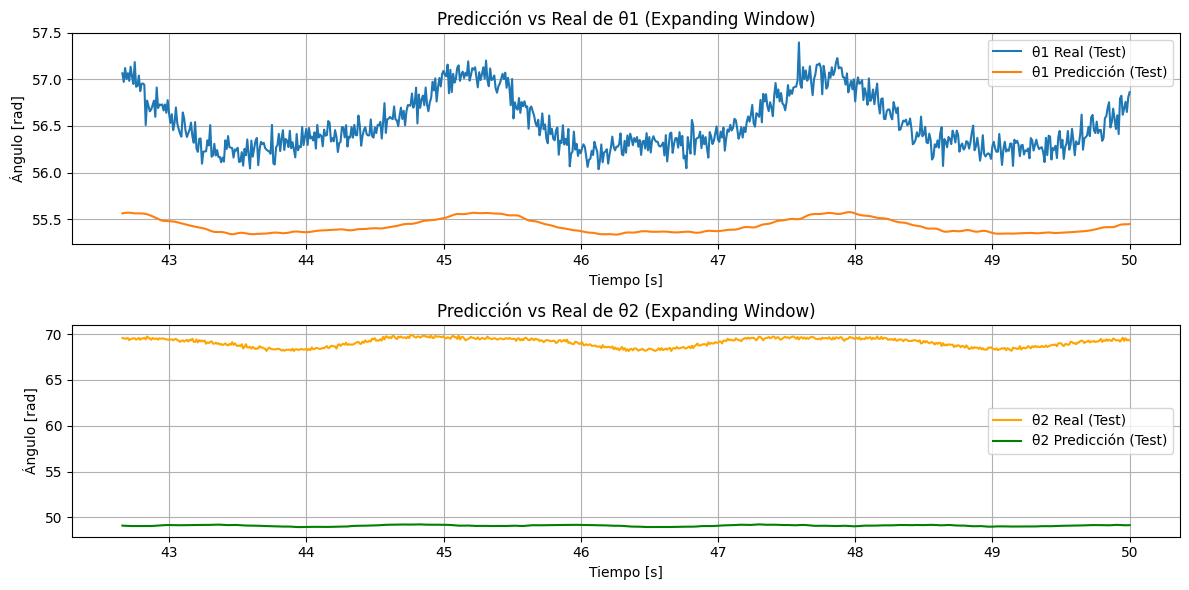

Métricas Globales en Test (Expanding Window):
MSE: 200.5615
MAE: 10.5467
R2: -899.3079


In [44]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

units=50

In [45]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(50, input_shape=(window_size, 2), return_sequences=True),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.4611 - r2_score: -91.0881 - val_loss: 0.5308 - val_r2_score: -36.6003
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.3678 - r2_score: -67.4574 - val_loss: 0.4228 - val_r2_score: -31.0574
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2477 - r2_score: -40.8055 - val_loss: 0.3059 - val_r2_score: -25.5876
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2071 - r2_score: -36.6112 - val_loss: 0.3031 - val_r2_score: -25.2964
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1586 - r2_score: -24.4467 - val_loss: 0.2489 - val_r2_score: -20.5116
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1281 - r2_score: -18.6691 - val_loss: 0.1697 - val_r2_score: -13.3825
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0752 - r2_score: -11.2661 - val_loss: 0.0749 - val_r2_score: -5.2246
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0148 - r2_score: -3.1352 - 

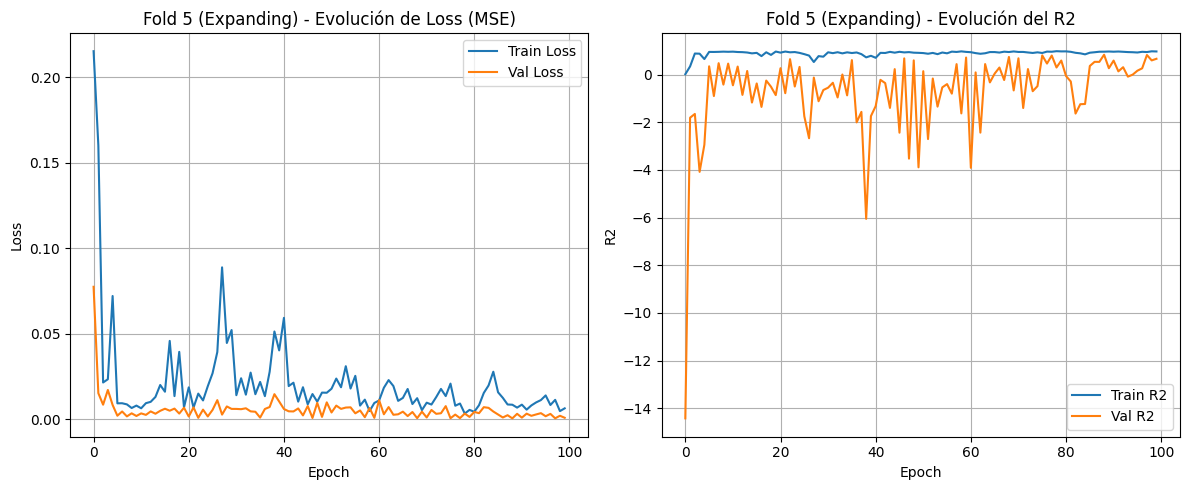

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


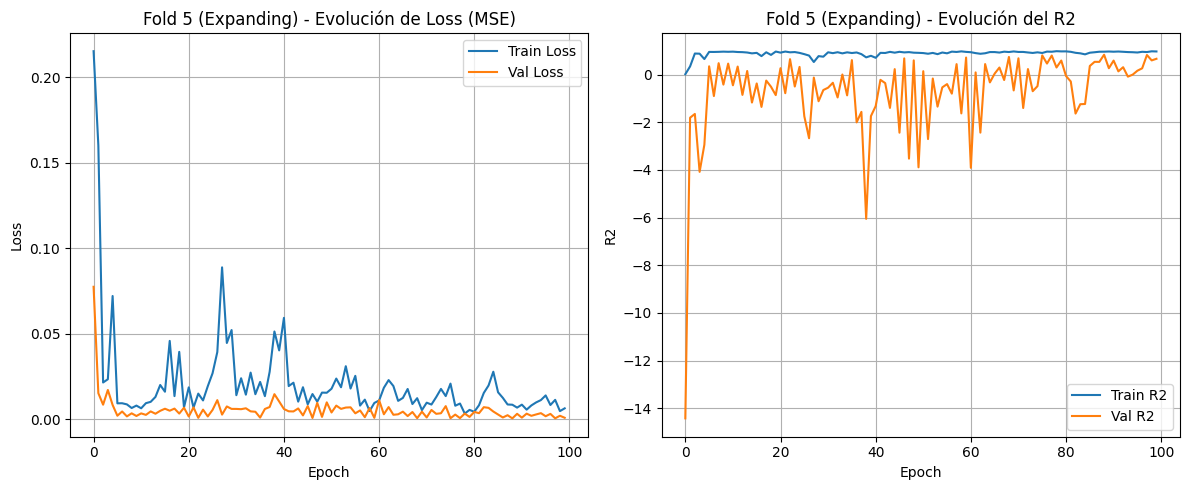

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


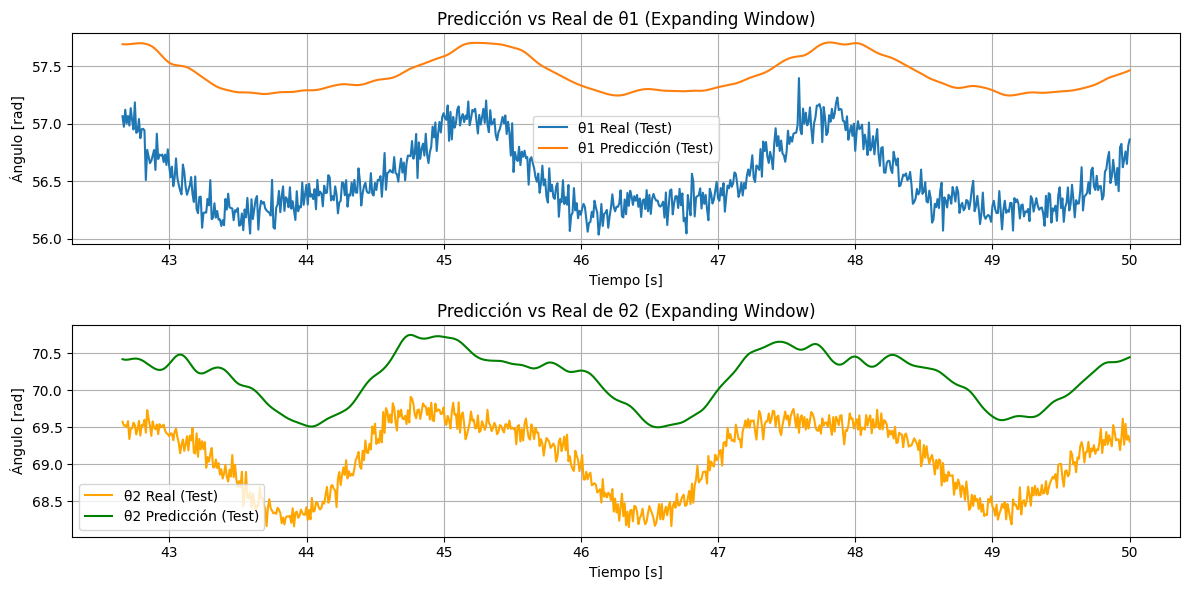

Métricas Globales en Test (Expanding Window):
MSE: 1.0226
MAE: 0.9887
R2: -6.6743


In [47]:
# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")

---

In [49]:
n_splits = 5

# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(50, input_shape=(window_size, 2), return_sequences=True),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1

print(f"Mejor fold (Expanding Window): Fold {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.4066 - r2_score: -81.0420 - val_loss: 0.4837 - val_r2_score: -37.1183
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.2440 - r2_score: -47.6760 - val_loss: 0.4870 - val_r2_score: -39.9058
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1704 - r2_score: -26.1490 - val_loss: 0.3716 - val_r2_score: -30.8779
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.1812 - r2_score: -25.8395 - val_loss: 0.3203 - val_r2_score: -25.4399
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1814 - r2_score: -25.8367 - val_loss: 0.2544 - val_r2_score: -19.6239
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1517 - r2_score: -23.3075 - val_loss: 0.1550 - val_r2_score: -10.6840
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0873 - r2_score: -14.0326 - val_loss: 0.0795 - val_r2_score: -4.4971
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0222 - r2_score: -3.1647 -

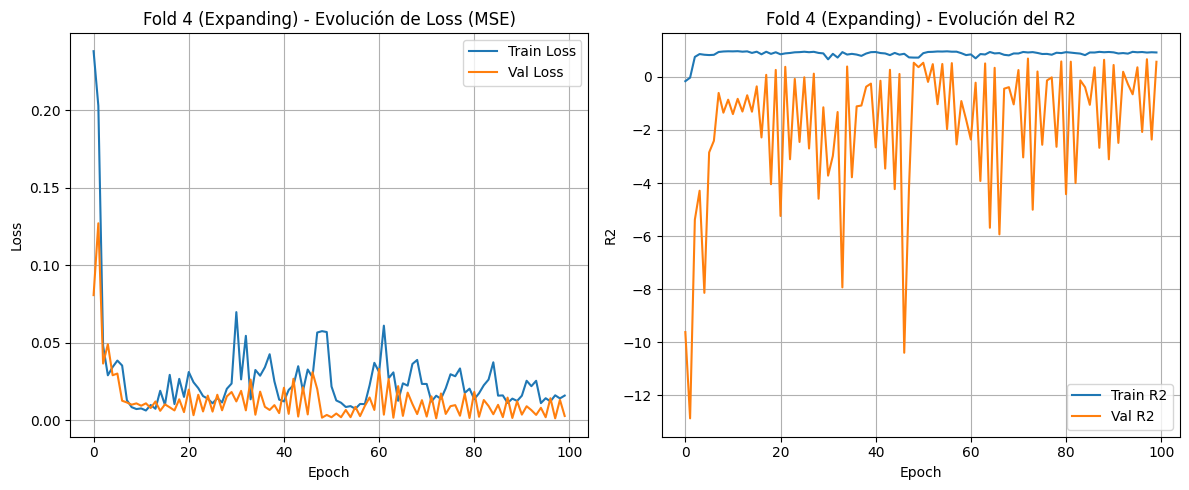

··················································
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


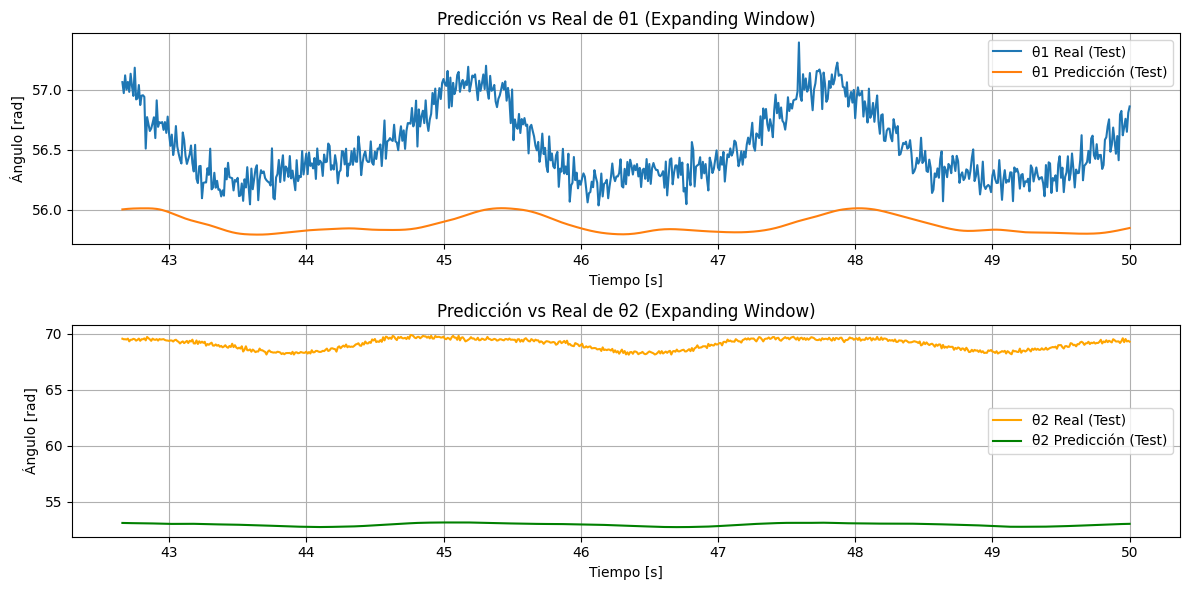

Métricas Globales en Test (Expanding Window):
MSE: 130.4107
MAE: 8.3922
R2: -583.1673


In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(best_history_exp['loss'], label='Train Loss')
ax1.plot(best_history_exp['val_loss'], label='Val Loss')
ax1.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución de Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(best_history_exp['r2_score'], label='Train R2')
ax2.plot(best_history_exp['val_r2_score'], label='Val R2')
ax2.set_title(f'Fold {best_fold_expanding} (Expanding) - Evolución del R2')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

print("·"*50)

# Predicciones en Test con el mejor modelo (Expanding Window)
Y_pred_test_exp = best_model_expanding.predict(X_test)
Y_pred_test_exp_inv = scaler_y.inverse_transform(Y_pred_test_exp)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# Gráficas Predicción vs Real
plt.figure(figsize=(12,6))

# θ1
plt.subplot(2,1,1)
plt.plot(t_test, Y_test_inv[:,0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_exp_inv[:,0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# θ2
plt.subplot(2,1,2)
plt.plot(t_test, Y_test_inv[:,1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_exp_inv[:,1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Expanding Window)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Métricas globales en test
mse_exp = mean_squared_error(Y_test_inv, Y_pred_test_exp_inv)
mae_exp = mean_absolute_error(Y_test_inv, Y_pred_test_exp_inv)
r2_exp_global = r2_score(Y_test_inv, Y_pred_test_exp_inv)

print("Métricas Globales en Test (Expanding Window):")
print(f"MSE: {mse_exp:.4f}")
print(f"MAE: {mae_exp:.4f}")
print(f"R2: {r2_exp_global:.4f}")